## HPF Observations of completely blank sky

In [a previous notebook](https://muler.readthedocs.io/en/latest/tutorials/refined_sky_subtraction.html) we illustrated how to refine HPF sky subtraction based on calibrated twilight flats.  Here we acquire novel calibration data of completely blank sky to measure the ratio between sky lines without the vagueries of pesky continuum.

In [1]:
from muler.hpf import HPFSpectrum, HPFSpectrumList

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

You can retrieve these data from the [muler example data GitHub site](https://github.com/OttoStruve/muler_example_data).  There are ten examples online, let's just look at one of those.

In [2]:
online_path = 'https://github.com/OttoStruve/muler_example_data/raw/main/HPF/02_blank_sky/'
filename = 'Goldilocks_20210825T052211_v1.0_0021.spectra.fits'
spectra = HPFSpectrumList.read(online_path+filename)

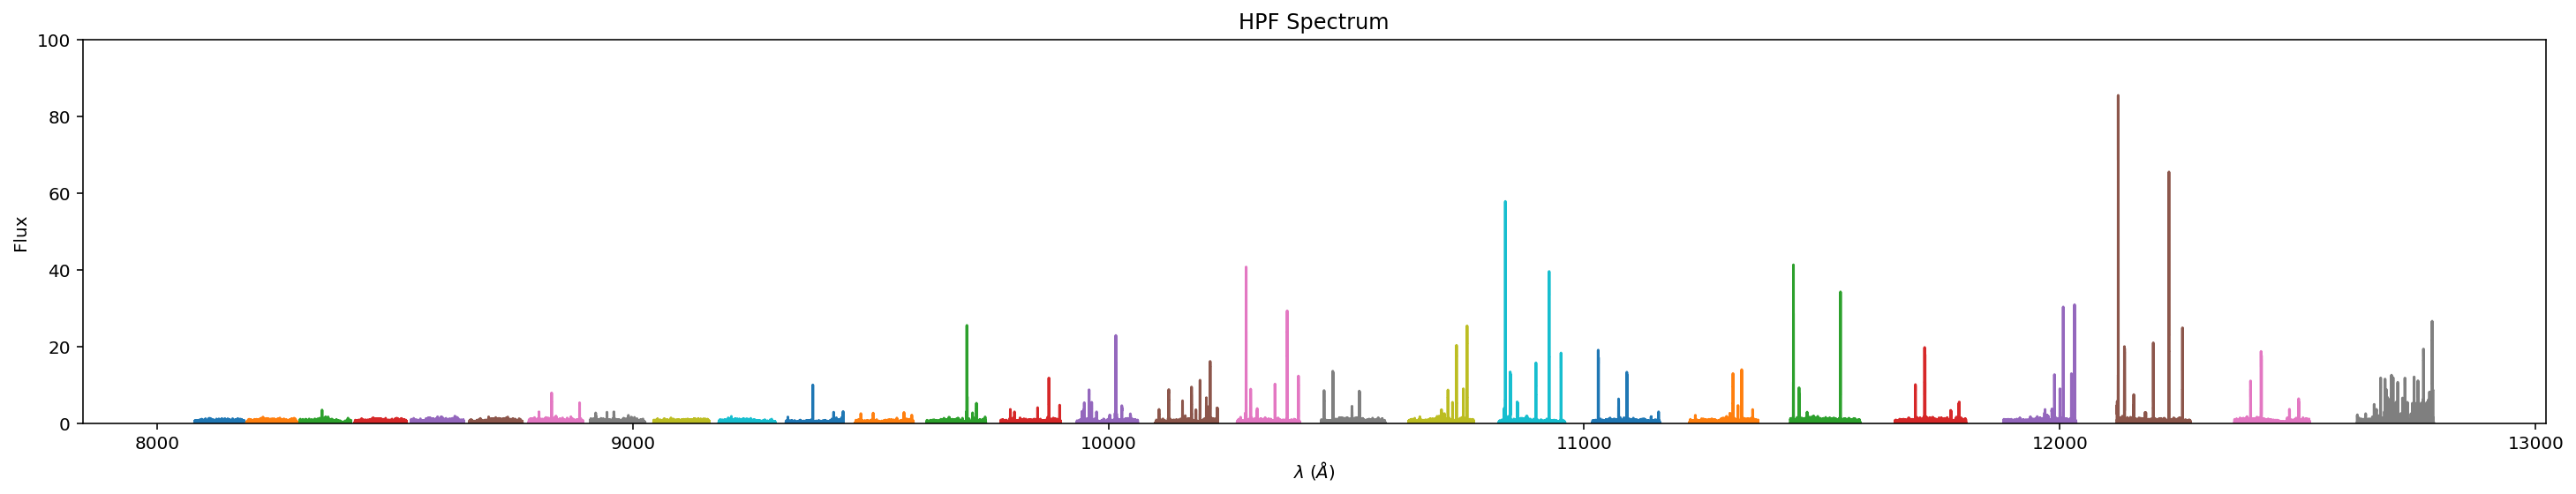

In [3]:
spectra.plot(ylo=0, yhi=100);

Neat, we see sky emission lines across the spectrum.  Let's take a look up close:

In [4]:
spectrum = spectra[19]

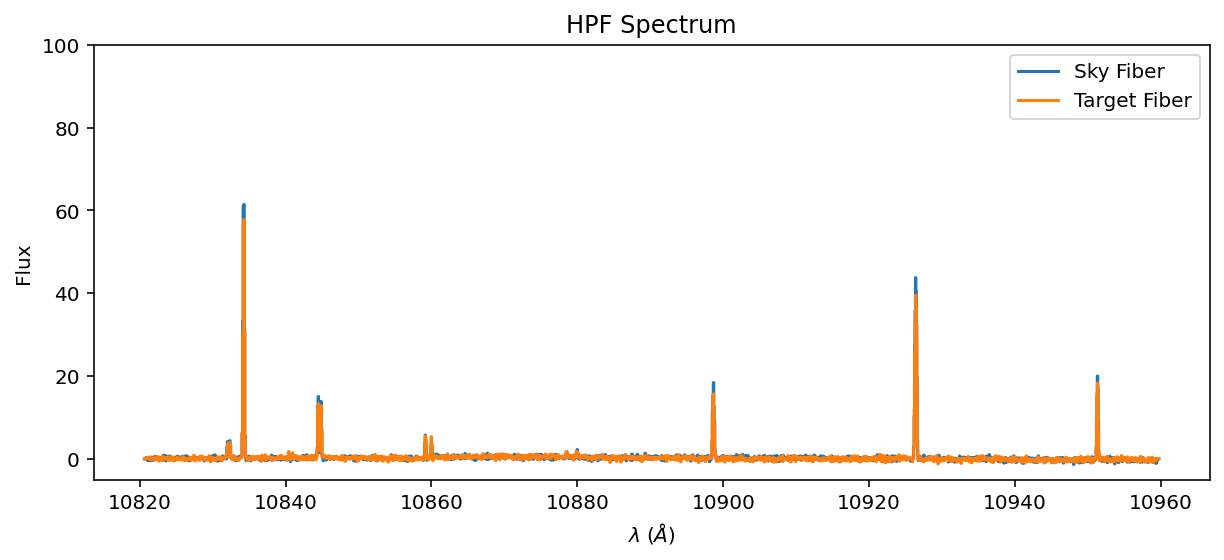

In [5]:
ax= spectrum.sky.plot(ylo=-5, yhi=100, label='Sky Fiber');
spectrum.plot(ax=ax, label='Target Fiber');
ax.legend();

Neat! We see slight differences between the two fibers.  Let's drill down even more to see how the different sky-subtraction methods perform:

This method is known to oversubtract the sky, see GitHub Issues.
Experimental feature, report any Issues on GitHub


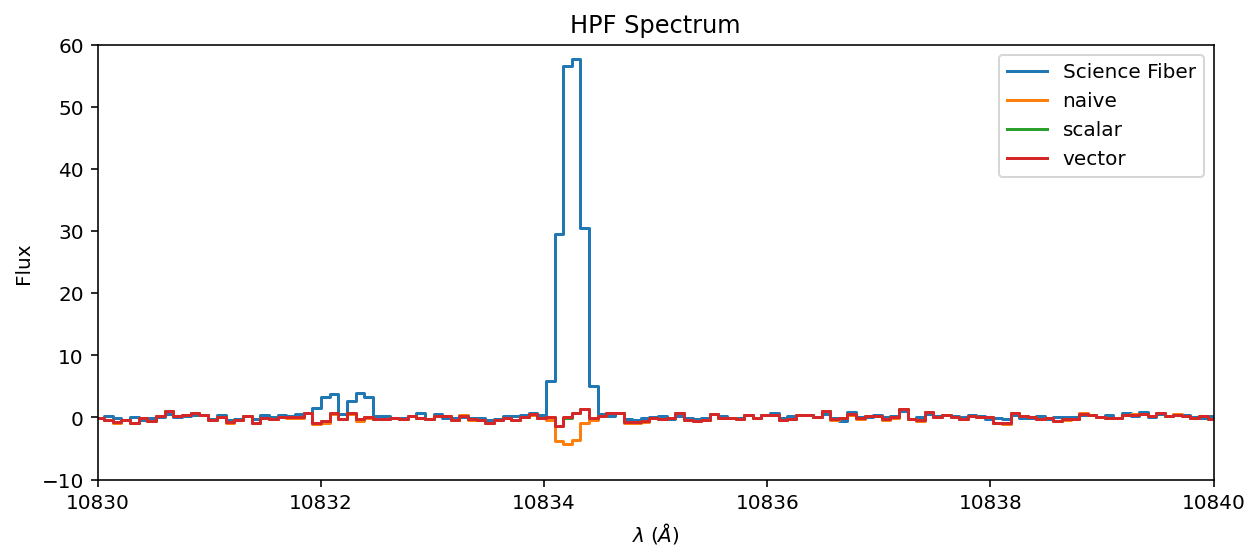

In [6]:
ax = spectrum.plot(label='Science Fiber');
for method in ['naive', 'scalar', 'vector']:
    spectrum.sky_subtract(method=method).plot(ax=ax, label=method);
    
ax.set_xlim(10_830, 10_840)
ax.set_ylim(-10, 60)
ax.legend();

Indeed the naive approach (orange) over-subtracts, leaving a conspicuous dip.  The scalar and vector corrections both work fine!

## Compute the Science-to-sky fiber ratio over the entire HPF bandpass

Let's look at all the high signal-to-noise ratio sky emission lines--- do they have the same ratios?

In [7]:
import numpy as np
from specutils.manipulation import LinearInterpolatedResampler, SplineInterpolatedResampler
resampler = SplineInterpolatedResampler()

In [8]:
twilight_ratio_raw = spectrum.get_static_sky_ratio_template()

In [9]:
full_science = spectra.stitch()

Experimental method


There's no convenience method for sky or uncertainty stitching (yet) so we have to spell-it-out:

In [10]:
full_sky = HPFSpectrumList([resampler(spec.sky, spec.spectral_axis) for spec in spectra]).stitch()
full_snr = HPFSpectrumList([spec/spec.uncertainty.array for spec in spectra]).stitch()

Experimental method
Experimental method


Let's just pick the very high SNR pixels.

In [11]:
full_mask = full_snr.flux.value > 40

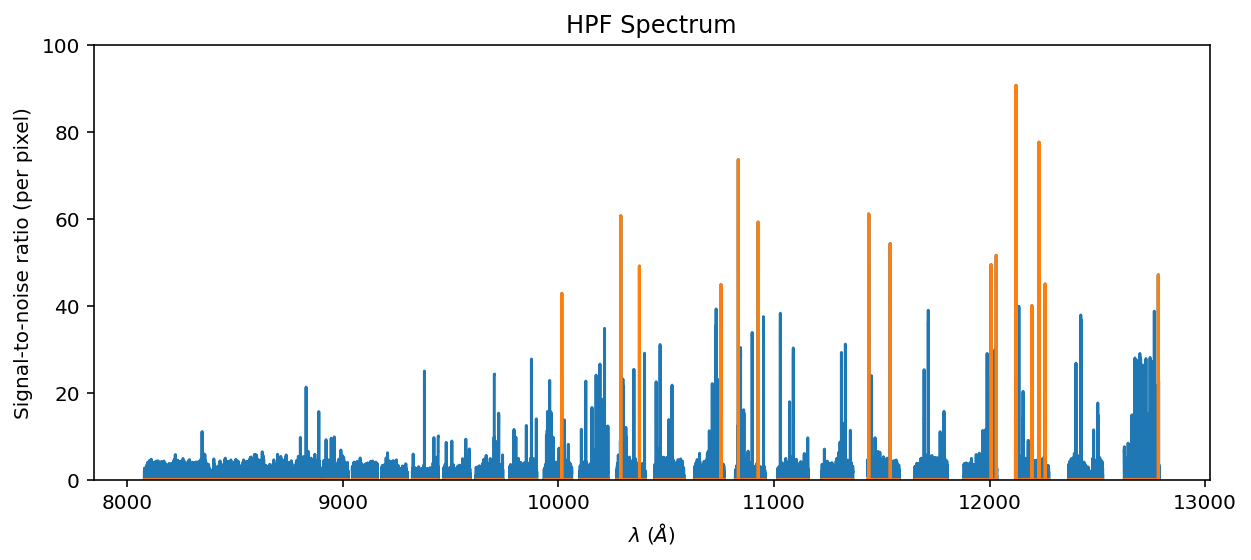

In [12]:
ax = full_snr.plot(ylo=0, yhi=100)
(full_snr*full_mask).plot(ax=ax);
ax.set_ylabel('Signal-to-noise ratio (per pixel)');

Looks good, we are focusing on the highest-SNR emission lines.

In [13]:
full_ratio = full_science.divide(full_sky, handle_meta='ff').multiply(full_mask*full_science.flux.unit)

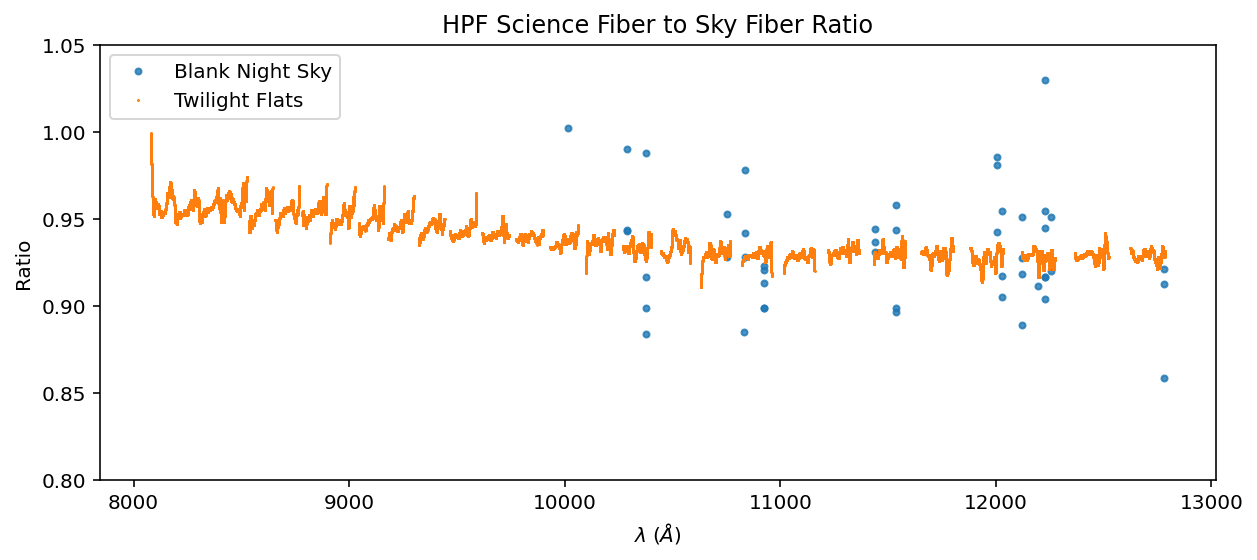

In [14]:
ax = full_ratio.plot(ylo=0.8, yhi=1.1, linestyle='none', marker='o', ms=3, alpha=0.8, label='Blank Night Sky')
twilight_ratio_raw.plot(ax=ax, linestyle='none', marker='.', ms=1, label='Twilight Flats');

ax.set_title('HPF Science Fiber to Sky Fiber Ratio')
    
ax.set_ylabel('Ratio')
ax.set_ylim(0.8, 1.05)
ax.legend();

Nice, we get about the same answer and trend using these data and the twilight flat data.  Se see a high amount of scatter, but comparable to the scatter seen in the twilight flats themeselves (not shown).  Overall the scatter must come in part from random noise, and possible some weak trends from genuine physics-- truly different atmospheric temperatures, airmasses, pressures, wind shears, etc. 

## Deep dive: Do sky-free pixels show any other artifacts?

The background flux in most pixels is so close to zero that the denominator in the ratio has many near-zero values, sending the ratio spectrum to near-infinity. Here we compute the difference spectrum---scaled by the twilight flat vector---and divided by the Goldilocks-reported uncertainty vector. Most of the nominally empty pixels in the difference vector constructed in this way should have mean value of zero with a propagated $\sigma$ of $\sqrt{1^2 + 0.93^2}$. 

In [15]:
from scipy.stats import norm
import celerite2
from celerite2 import terms

In [16]:
full_twilight_ratio = resampler(twilight_ratio_raw, full_science.spectral_axis)

Compute the residual, and normalize by the uncertainty.

$\mathbf{r} = \mathbf{f}_{\star} - \mathbf{\beta} \; \odot \mathbf{f}_{\mathrm{sky}}$

In [17]:
residual = (full_science - full_twilight_ratio*full_sky)
sigmas = np.hstack([spec.uncertainty.array for spec in spectra])
residual_in_sigma = residual.flux.value/(np.hypot(1.0, 0.93)*sigmas)

Smooth the residual spectrum with a Gaussian Process.

In [18]:
mask = np.isfinite(residual_in_sigma)
x = residual.wavelength.value[mask]
y = residual_in_sigma[mask]
N_pix = len(x)

In [19]:
kernel = terms.SHOTerm(sigma=0.8, rho=200.0, Q=0.25)

gp = celerite2.GaussianProcess(kernel, mean=0.1)
gp.compute(x, yerr=np.ones(N_pix))

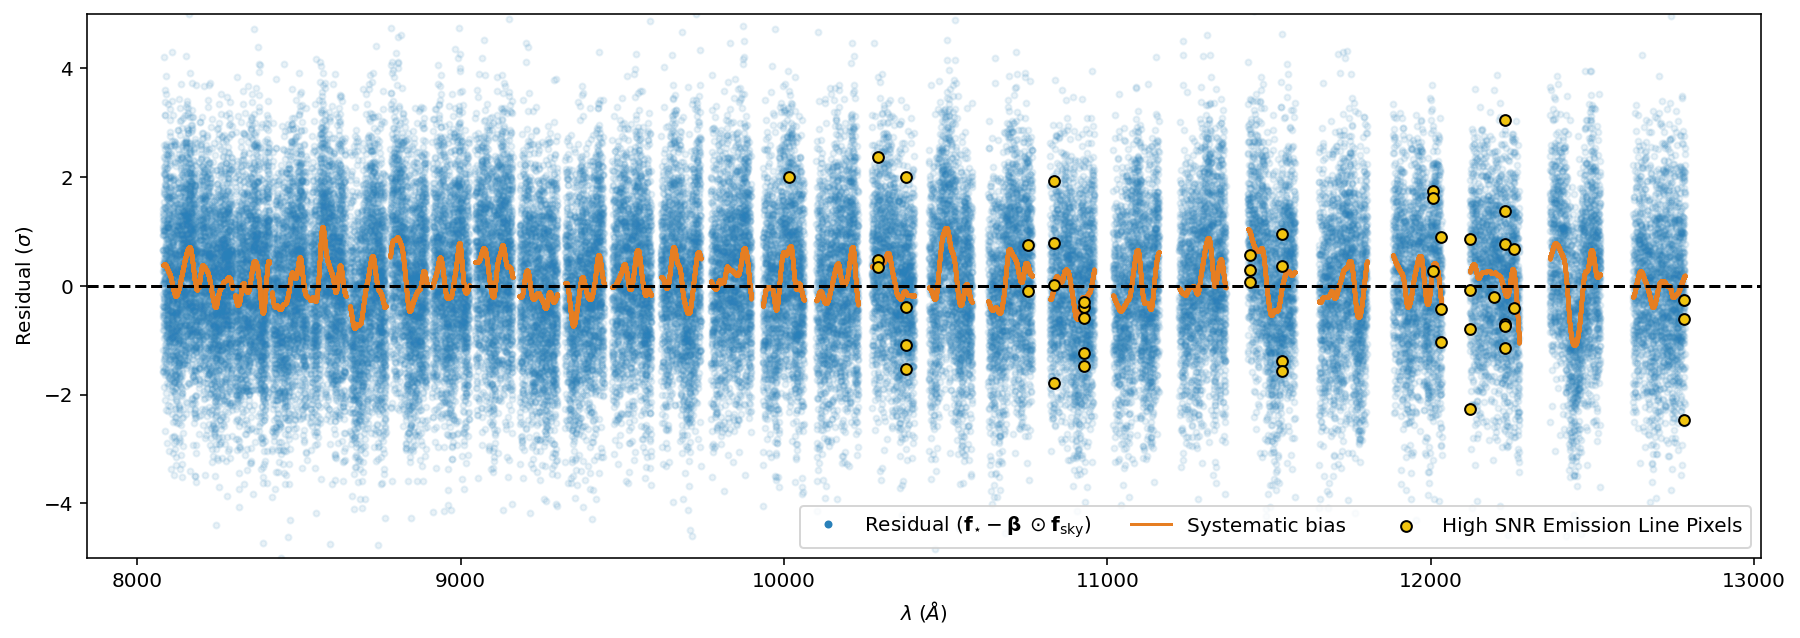

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(x, y, linestyle='none', marker='o', alpha=0.1, ms=3, color='#2980b9', label=None)
plt.plot(x, y*0-999, linestyle='none', marker='o', alpha=1, ms=3, color='#2980b9', 
         label=r'Residual ($\mathbf{f}_{\star} - \mathbf{\beta} \; \odot \mathbf{f}_{\mathrm{sky}})$')
plt.plot(x, gp.predict(y, x), linestyle='none', color='#e67e22', marker='.', ms=2, label=None)

plt.plot(x, y*0-999, color='#e67e22', label='Systematic bias')
#plt.plot(x, gp.predict(y_noise, x), linestyle='none', color='#95a5a6', marker='.', ms=2, label='IID')
plt.scatter(residual.wavelength.value[full_mask], residual_in_sigma[full_mask], 
         marker='o', s=29, ec='k', c='#f1c40f', zorder=10, label='High SNR Emission Line Pixels')
plt.axhline(0.0, color='k', linestyle='dashed')
plt.ylim(-5, 5)
plt.legend(ncol=3)
plt.xlabel('$\lambda \; (\AA)$')
plt.ylabel('Residual $(\sigma)$')
plt.savefig('../../paper/data_analysis_I/figures/Scaled_sky_residual_trend.png', dpi=300, bbox_inches='tight')

We see minor systematic trends with an amplitude of about <0.5 sigma, large enough to bloat the realized RMS from its expected value of $\sqrt{1^2 + 0.93^2}$.

We can make a histogram to quantify the bloating scale.

In [21]:
bins = np.arange(-15, 15, 0.2)

standard_normal = norm(loc=0, scale=1).pdf(bins)
refined_uncertainty = norm(loc=0.1, scale=1.3).pdf(bins)

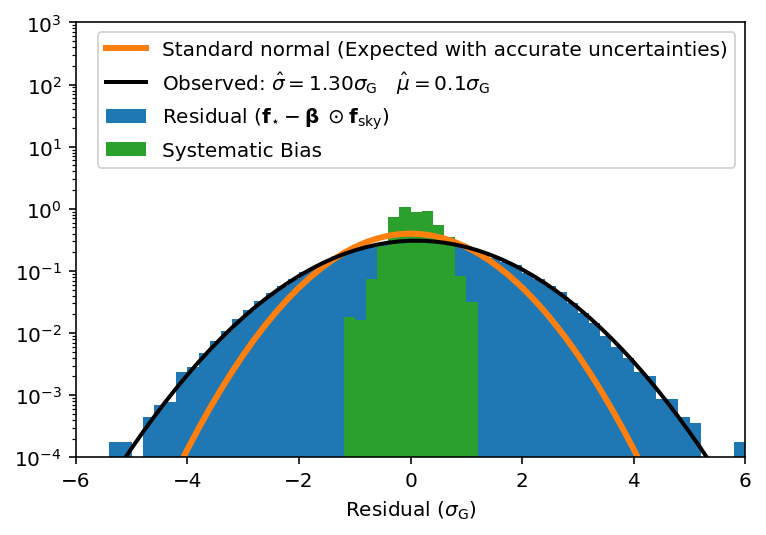

In [22]:
plt.hist(residual_in_sigma, bins=bins, density=True, label=r'Residual ($\mathbf{f}_{\star} - \mathbf{\beta} \; \odot \mathbf{f}_{\mathrm{sky}})$');
plt.plot(bins, standard_normal, lw=3,
         label='Standard normal (Expected with accurate uncertainties)');
plt.plot(bins, refined_uncertainty, lw=2, color='k',
         label='Observed: $\hat\sigma = 1.30\sigma_{\mathrm{G}} \quad \hat\mu = 0.1\sigma_{\mathrm{G}}$');
plt.xlabel('Residual ($\sigma_{\mathrm{G}}$)')

plt.hist(gp.predict(y, x), bins=bins, density=True, label='Systematic Bias');

plt.yscale('log')
plt.ylim(1e-4, 1e3)
plt.xlim(-6, 6)
#plt.hist(residual_in_sigma[full_mask], bins=coarse_bins, density=True, alpha=0.3)
plt.legend(loc='best')
plt.savefig('../../paper/data_analysis_I/figures/Scaled_sky_residual_uncertainty.png', dpi=300, bbox_inches='tight')

We see find a realized uncertainty of $1.3\times$ the expected value, in other words Goldilocks underestimates the uncertainty by 1.3x, attributable to this systematic bias trend.  I get the same trend if I use a scalar ($\bar \beta=0.93$) prefactor to the sky fiber, so I know I am not injecting this signal artificially from the twilight flats. All things considered, this systematic bias is pretty tiny and immaterial for most scientific applications.